## <center> Safe Sphere Demo Code </center>

In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

In [ ]:
import warnings
warnings.filterwarnings("ignore")

## Load Data

In [ ]:
unauthorized_device = pd.DataFrame(columns=['ClientMacAddr', 'time', 'recheck_time', 'SecurityArea'])
test_1 = pd.read_csv('rougue_before.csv') # data for 1st test
test_2 = pd.read_csv('rougue.csv')  # data for 2nd test 
authorized_device = pd.read_csv('authorized_device.csv') # list of authorized devices for each security area
security_area = pd.read_csv('security_area.csv') # location of security areas
employee_identity = pd.read_csv('employee_identity.csv') # identity of employees
original = pd.read_csv('2019-08-13-cleaned.csv') # data of 2019-08-13
camera = pd.read_csv('camera.csv') # location of surveillance camera
photo = pd.read_csv('photo.csv') # photo database of surveillance camera
stair=pd.read_csv("stair.csv") # location of stairs

## Define function

### 1. Devide building into zones

In [ ]:
def assign_zones(dataframe, x_min, x_max, y_min, y_max, k):
    # Define the x and y boundaries of the grid
    x_step = (x_max-x_min)/k
    y_step = (y_max-y_min)/k

    # assign zone number for the given dataframe
    zone_num = 1
    for i in range(k):
        for j in range(k):
            x = x_min + i * x_step
            y = y_min + j * y_step
            mask = ((dataframe['lng'] >= x) & (dataframe['lng'] <= x + x_step) &
                    (dataframe['lat'] >= y) & (dataframe['lat'] <= y + y_step))
            dataframe.loc[mask, 'ZoneID'] = zone_num
            zone_num += 1
    dataframe['ZoneID'] = dataframe['ZoneID'].astype(int)
    return dataframe

### 2. Check whether a device has enters a secured area

In [ ]:
def check_device_access(df, security_area, authorized_device, unauthorized_device, t):
    
    """
    Checks whether a device has access to a security area.
    
    Args:
        df (pandas.DataFrame): The input data frame with columns 
            ClientMacAddr, localtime, Site, Level, lat, lng, and ZoneID.
        security_area (pandas.DataFrame): The security area data frame with columns 
            SecurityArea, ZoneID, AccessLevel, and Level.
        authorized_device (pandas.DataFrame): The authorized device data frame with columns 
            ZoneID, ClientMacAddr, and Level.
        unauthorized_device (pandas.DataFrame): The unauthorized device data frame with columns 
            ClientMacAddr, time, recheck_time, and SecurityArea.
        t (int): The number of minutes to wait before checking again for unauthorized access.
    
    Returns:
        alert_df (pandas.DataFrame): A dataframe records every alert triggered.
    """
    # Create an empty DataFrame to store rows where an alert is triggered
    alert_df = pd.DataFrame()

    # Check if input's ZoneID and Level match any of the records in security_area
    for index, row in df.iterrows():
        match = security_area[(security_area['ZoneID'] == row['ZoneID'])
                              & (security_area['Level'] == row['Level'])]
        if match.empty:
            continue  # No match found, move to next row
        else:
            # Add SecurityArea column and check if input device is authorized
            row['SecurityArea'] = match['SecurityArea'].iloc[0]
            authorized = authorized_device[(authorized_device['ZoneID'] == row['ZoneID']) &
                                           (authorized_device['ClientMacAddr'] == row['ClientMacAddr']) &
                                           (authorized_device['Level'] == row['Level'])]
            if not authorized.empty:
                continue  # Device is authorized, move to next row
            else:
                # Check if input device is unauthorized
                unauthorized = unauthorized_device[(unauthorized_device['ClientMacAddr'] == row['ClientMacAddr']) &
                                                   (unauthorized_device['SecurityArea'] == row['SecurityArea'])]
                if unauthorized.empty:
                    # Create new unauthorized record
                    now = datetime.strptime(row['localtime'], '%Y-%m-%d %H:%M:%S')
                    unauthorized_device = unauthorized_device.append({'ClientMacAddr': row['ClientMacAddr'],
                                                                      'time': now,
                                                                      'recheck_time': now + timedelta(minutes=t),
                                                                      'SecurityArea': row['SecurityArea']},
                                                                     ignore_index=True)
                    alert = f"Detected unauthorized access by {row['ClientMacAddr']} at {row['localtime']} in {row['SecurityArea']}"
                    # Add row to alert_df
                    alert_row = row.copy()
                    alert_row['alert'] = alert
                    alert_df = alert_df.append(alert_row, ignore_index=True)
                else:
                     # Check if recheck_time has elapsed
                    if len(unauthorized) > 0:
                        recheck_time = unauthorized['recheck_time'].iloc[0]
                        now = datetime.strptime(row['localtime'], '%Y-%m-%d %H:%M:%S')
                        if now <= recheck_time:
                            continue  # Recheck time has not elapsed, move to next row
                        else:
                            # Overwrite existing unauthorized record
                            now = datetime.strptime(row['localtime'], '%Y-%m-%d %H:%M:%S')
                            unauthorized_device.loc[(unauthorized_device['ClientMacAddr'] == row['ClientMacAddr']) &
                                            (unauthorized_device['SecurityArea'] == row['SecurityArea']),
                                            ['time', 'recheck_time']] = [now, now + timedelta(minutes=t)]
                   
                    # Device is still unauthorized, send alert and update record
                    alert = f"Detected unauthorized access by {row['ClientMacAddr']} at {row['localtime']} in {row['SecurityArea']}"

                    # Add row to alert_df
                    alert_row = row.copy()
                    alert_row['alert'] = alert
                    alert_df = alert_df.append(alert_row, ignore_index=True)
    return alert_df

### 3. Search for Security Guard

In [ ]:
def find_security(entity):
    list_1=[]
    list_2=[]
    list_3=[]
    for index,row in entity.iterrows():
        if row['EmployeeRole']=='Security Guard':
            list_1.append(row['ClientMacAddr'])
            list_2.append(row['Email'])
    return pd.DataFrame({'ClientMacAddr':list_1,'Email':list_2})

In [ ]:
def find_employee(dataframe,time):
    list_1=[]
    list_2=[]
    list_3=[]
    list_4=[]
    time=datetime.strptime(time, '%Y-%m-%d %H:%M:%S')
    for index,row in dataframe.iterrows():
        if (time-datetime.strptime(row['date']+' '+row['time'],'%Y-%m-%d %H:%M:%S')).seconds<=600:
            list_1.append(row['ClientMacAddr'])
            list_2.append(row['lat'])
            list_3.append(row['lng'])
            list_4.append(row['Level'])
    data=pd.DataFrame({'ClientMacAddr':list_1,'lat':list_2,'lng':list_3,'Floor':list_4})
    return data

In [ ]:
def initial(k):
    frame_1=np.zeros([k,k])
    frame_2=np.zeros([k,k])
    frame_3=np.zeros([k,k])
    frame_4=np.zeros([k,k])
    list=[]
    list.append(frame_1)
    list.append(frame_2)
    list.append(frame_3)
    list.append(frame_4)
    return list

poly=[[[0,2],[0,8],[12,7],[14,19],[19,19],[17,0],[0,2]]]


def find_email(zone,security_final):
    for index,row in security_final.iterrows():
        if row['ZoneID']==zone:
            return row['ClientMacAddr']

# project ZoneID into coordinates
def transfer_1(num,k):
    yy=num%k-1
    if yy<0:
        yy=19
    xx=int((num-yy)/k)
    return(xx,yy)
def transfer(num,k):
    yy=num%k-1
    if yy<0:
        yy=19
    xx=int(num/k)
    return(xx,yy)

def de_transfer(xx,yy,k):
    return xx*k+yy+1

# transfer floor level into number
def tran_floor(string):
    if string=='Ground Floor':
        return 0
    elif string=='1st Floor':
        return 1
    elif string=='2nd Floor':
        return 2
    elif string=='3rd Floor':
        return 3

# initialize stair location
list_stair=[]
for i in range(0,3):
    point=(transfer_1(stair.iloc[i][1],20)[0],transfer_1(stair.iloc[i][1],20)[1])
    list_stair.append(point)


def floor_info(dataframe,k):
    for i in range(0,dataframe.shape[0]):
        point=transfer(dataframe.iloc[i][5],k)
        list[tran_floor(dataframe.iloc[i][3])][point[0]][point[1]]=1
    return list


def isRayIntersectsSegment(xx,yy,s_poi,e_poi): #[x,y] [lng,lat]
    #输入：判断点，边起点，边终点，都是[lng,lat]格式数组
    if s_poi[1]==e_poi[1]: #排除与射线平行、重合，线段首尾端点重合的情况
        return False
    if s_poi[1]>yy and e_poi[1]>yy: #线段在射线上边
        return False
    if s_poi[1]<yy and e_poi[1]<yy: #线段在射线下边
        return False
    #if s_poi[1]==yy and e_poi[1]>yy: #交点为下端点，对应spoint
        #return False
    if e_poi[1]==yy and s_poi[1]>yy: #交点为下端点，对应epoint
        return False
    if s_poi[0]<xx and e_poi[1]<xx: #线段在射线左边
        return False

    xseg=e_poi[0]-(e_poi[0]-s_poi[0])*(e_poi[1]-yy)/(e_poi[1]-s_poi[1]) #求交
    if xseg<xx: #交点在射线起点的左侧
        return False
    return True  #排除上述情况之后

def isPoiWithinPoly(xx,yy,poly):
    #输入：点，多边形三维数组
    #poly=[[[x1,y1],[x2,y2],……,[xn,yn],[x1,y1]],[[w1,t1],……[wk,tk]]] 三维数组

    #可以先判断点是否在外包矩形内
    #if not isPoiWithinBox(poi,mbr=[[0,0],[180,90]]): return False
    #但算最小外包矩形本身需要循环边，会造成开销，本处略去
    sinsc=0 #交点个数
    for epoly in poly: #循环每条边的曲线->each polygon 是二维数组[[x1,y1],…[xn,yn]]
        for i in range(len(epoly)-1): #[0,len-1]
            s_poi=epoly[i]
            e_poi=epoly[i+1]
            if isRayIntersectsSegment(xx,yy,s_poi,e_poi):
                sinsc+=1 #有交点就加1

    return True if sinsc%2==1 else  False

#以点(xx,yy)为中心搜索
def search_floor(k,floor,xx,yy):
    for i in range(xx-k,xx+k+1):
        for j in range(yy-k,yy+k+1):
            if isPoiWithinPoly(i,j,poly)==True:
                #print(i,j)
                if list[floor-1][i][j]==1:
                    return (i,j)
    return 0

#print(search_floor(3,2,1,10))
#k:搜索范围  m:上下m层楼检索
def search_total(k,floor,m,sub,xx,yy,stairx,stairy):
    #本层楼再扩大范围检索
    id=search_floor(k,floor,xx,yy)
    if id!=0:
        return id
    #上下一层楼检索
    if m==1:
        #print("上下1层")
        #print(k-sub)
        if floor + 1 < 4:
            id = search_floor(k - sub, floor + 1,stairx,stairy)
            if id != 0:
                return id
        if floor - 1 >=0:
            id = search_floor(k - sub, floor - 1,stairx,stairy)
            if id != 0:
                return id
    if m==2:
        #print("上下2层")
        if floor + 1 < 4:
            id = search_floor(k - sub, floor + 1,stairx,stairy)
            if id != 0:
                return id
        if floor - 1 >= 0:
            id = search_floor(k - sub, floor - 1,stairx,stairy)
            if id != 0:
                return id
        if floor + 2 < 4:
            id = search_floor(k - sub-1, floor + 2,stairx,stairy)
            if id != 0:
                return id
        if floor - 2 >= 0:
            id = search_floor(k - sub-1, floor - 2,stairx,stairy)
            if id != 0:
                return id
    if m==3:
        #print("上下3层")
        if floor + 1 < 4:
            id = search_floor(k - sub, floor + 1,stairx,stairy)
            if id != 0:
                return id
        if floor - 1 >= 0:
            id = search_floor(k - sub, floor - 1,stairx,stairy)
            if id != 0:
                return id
        if floor + 2 < 4:
            id = search_floor(k - sub-1, floor + 2,stairx,stairy)
            if id != 0:
                return id
        if floor - 2 >= 0:
            id = search_floor(k - sub-1, floor - 2,stairx,stairy)
            if id != 0:
                return id
        if floor + 3 < 4:
            id = search_floor(k - sub-2, floor + 3,stairx,stairy)
            if id != 0:
                return id
        if floor - 3 >= 0:
            id = search_floor(k - sub-2, floor - 3,stairx,stairy)
            if id != 0:
                return id
    return 0


def search(xx,yy,floor):
    #首先搜索本层楼
    #计算k:初始值为该格子到最近的电梯的距离
    if xx<=10 and yy<=10:
        sub=max(xx,10-yy)
        stairx, stairy = list_stair[0][0],list_stair[0][1]
    if xx>10 and yy<=10:
        sub=max(17-xx,yy)
        stairx, stairy = list_stair[1][0],list_stair[1][1]
    if xx>10 and yy>10:
        sub=max(19-xx,19-yy)
        stairx, stairy = list_stair[2][0],list_stair[2][1]
    k=sub
    for i in range(1,k+1):
        id=search_floor(i,floor,xx,yy)
        if id!=0:
            return id
    k=k+1
    m=1
    #若本层楼检索到最近的楼梯处依旧无人，则开始检索上下m层楼是否有人
    while k<=18:
        id=search_total(k,floor,m,sub,xx,yy,stairx,stairy)
        if id==0:
            k=k+1
            m=m+1
            if m>3:
                m=3
        else:
            return id
    return 0

In [ ]:
def find_email(zone,security_final):
    for index,row in security_final.iterrows():
        if row['ZoneID']==zone:
            return row['ClientMacAddr']

In [ ]:
def exe(entity,original,test):
    security=find_security(entity)
    data=find_employee(original,test.iloc[0][1])
    security_final=pd.merge(left=data,right=security,how='inner',on='ClientMacAddr')
    dataframe=assign_zones(security_final,x_min, x_max, y_min, y_max, k)
    floor_info(dataframe,k)
    point = search(transfer(test.iloc[0][6], k)[0], transfer(test.iloc[0][6],k)[1], tran_floor(test.iloc[0][3]))
    return find_email(de_transfer(point[0],point[1],k),dataframe)

### 4. Send alert email to the cloest security guard availble

In [ ]:
def security_email_content (security_guard, device):
    for i, row in security_guard.iterrows():
        print('Send to:' + row['Email'])
        employee_message = f"Dear {row['EmployeeName']}, \n"
        print(employee_message)
    for i, row in device.iterrows():
        alert_message = f"An unauthorized device ({row['ClientMacAddr']}) appears in the {row['SecurityArea']} at {row['localtime']}. \nThe location is {row['Level']}, and the zone id is {row['ZoneID']}.\n"
        print(alert_message)
        print('Please investigate on-site as soon as possible!')

In [ ]:
def attach_photo(device, camera, photo):
    find_camera = pd.merge(device, camera, on='SecurityArea')
    find_photo = pd.merge(find_camera, photo, left_on =["localtime","Camera ID"], right_on=["time","Camera ID"])
    print(find_photo["photo"][0])

## <center>------Test Run------ </center>

### 1. Initiate Building and Grid information

In [ ]:
x_min, x_max = -0.9332446313023279, -0.9321732468412318
y_min, y_max= 51.460257062787136, 51.46094763183397 
k = 20

### 2. Test 1: 00:10:00 ~ 00:10:59

In [ ]:
%%time
assign_zones(test_1, x_min, x_max, y_min, y_max, k)
output1 = check_device_access(test_1, security_area, authorized_device, unauthorized_device, t=10)
result1 = output1.iloc[-1].to_frame().T.reset_index(drop = True)
list=initial(20)
macid1=exe(employee_identity,original,result1)
security_guard = employee_identity[employee_identity['ClientMacAddr']==macid1]
security_email_content(security_guard, result1)
attach_photo(result1, camera, photo)

Send to:miku.pérez@company.com
Dear Miku Pérez, 

An unauthorized device (d0:e4:0b:fb:a2:6c) appears in the data_center at 2019-08-13 00:10:07. 
The location is 3rd Floor, and the zone id is 308.

Please investigate on-site as soon as possible!
IMG_20190813_001007.JPG
CPU times: total: 1min 7s
Wall time: 2min 12s


### 3. Test 2: 00:10:00 ~ 00:20:59

In [ ]:
%%time
assign_zones(test_2, x_min, x_max, y_min, y_max, k)
output2 = check_device_access(test_2, security_area, authorized_device, unauthorized_device, t=10)
result2 = output2.iloc[-1].to_frame().T.reset_index(drop = True)
list=initial(20)
macid2=exe(employee_identity,original,result2)
security_guard = employee_identity[employee_identity['ClientMacAddr']==macid2]
security_email_content(security_guard, result2)
attach_photo(result2, camera, photo)

Send to:miku.pérez@company.com
Dear Miku Pérez, 

An unauthorized device (d0:e4:0b:fb:a2:6c) appears in the data_center at 2019-08-13 00:20:17. 
The location is 3rd Floor, and the zone id is 308.

Please investigate on-site as soon as possible!
IMG_20190813_002017.JPG
CPU times: total: 57.5 s
Wall time: 2min 10s


## Graph

In [ ]:
rougue = pd.read_csv('rougue.csv')

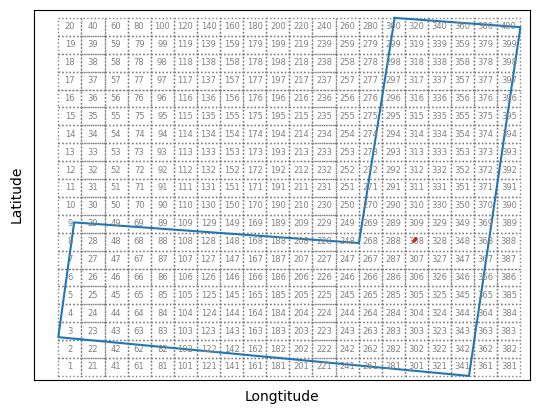

In [ ]:
import matplotlib.pyplot as plt
x_step = (x_max-x_min)/k
y_step = (y_max-y_min)/k
for i in range(k):
    for j in range(k):
        x = x_min + i * x_step
        y = y_min + j * y_step
        rect = plt.Rectangle((x, y), x_step, y_step, 
                             fill=False, color='gray', linestyle='dotted', linewidth = 1)
        plt.gca().add_patch(rect)
        plt.text(x+x_step/2, y+y_step/2, f'{i*k+j+1}', 
                 ha='center', va='center', fontsize = 6, color='gray')

# Plot the points - change 'fix1_date' to any dataframe you want to plot
plt.scatter(rougue['lng'], rougue['lat'], s=1, color='red')


# Plot the enclosed shape
b = [51.46094763183397, 
     51.46092976598236,
     51.460257062787136,
     51.46033182761984,
     51.46055317954987,
     51.46051343244503,
     51.46094763183397]
a = [-0.9324647751707785,
     -0.9321732468412318,
     -0.9322924232674887,
     -0.9332446313023279,
     -0.9332078677279798,
     -0.9325475994237232,
     -0.9324647751707785]
plt.plot(a,b)

# Set the x and y limits of the plot
plt.xlim(-0.9333, -0.93215)
plt.ylim(51.46025, 51.460962917873445)

# Remove the x ticks and y ticks
plt.xticks([])
plt.yticks([])

# Set the x and y labels of the plot
plt.xlabel('Longtitude')
plt.ylabel('Latitude')

# Show the plot
plt.show()